## Run this cell only if you are working in Google Colab

In [ ]:
import os, datetime
from google.colab import drive

drive.mount('/content/drive')

PATH = os.path.join('drive','MyDrive','hands-free_cursor')
os.chdir(os.path.join(PATH,'src'))
os.listdir()

## Importing libraries and modules

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import pandas as pd
import numpy as np
import pickle
import time
import json
import cv2
import os

# Data preparation

## Load CSV and JSON data

In [3]:
INPUT_PATH = os.path.join('..', 'data')

data = None
for sub_num, subject in enumerate(os.listdir(INPUT_PATH)):
    for ses_num, session in enumerate(os.listdir(os.path.join(INPUT_PATH, subject))):
        csv_path = glob(os.path.join(INPUT_PATH, subject, session, '*.csv'))[0]
        json_path = glob(os.path.join(INPUT_PATH, subject, session, '*.json'))[0]

        # Loading data
        temp_df = pd.read_csv(csv_path)
        with open(json_path, 'r') as file:
            session_data = json.load(file)
        assert session_data['images']==temp_df.shape[0], f'Incorrect number of images in:\n{subject}\n{session}'

        # Creating new columns
        temp_df['subject'] = ['subject_'+str(sub_num)]*session_data['images']
        temp_df['file_name'] = temp_df['file_name'].apply(lambda x: os.path.join(INPUT_PATH, subject, session, 'images', x))
        temp_df = temp_df.rename(columns={'file_name':'file_path'})

        if sub_num==0 and ses_num==0:
            data = temp_df
        else:
            data = pd.concat([data,temp_df], axis=0)
data = data.reset_index().drop('index',axis=1)

data.head()

,file_path,ref_x,ref_y,ref_w,ref_h,kpt1_x,kpt1_y,kpt2_x,kpt2_y,kpt3_x,kpt3_y,kpt4_x,kpt4_y,kpt5_x,kpt5_y,kpt6_x,kpt6_y,label,subject
0,../data/subject_0/2023_09_06-19_06_58/images/0...,0.467098,0.388244,0.261640,0.348852,0.552614,0.473904,0.659617,0.472428,0.611631,0.545088,0.608068,0.624877,0.481930,0.525672,0.710058,0.525424,0,subject_0
1,../data/subject_0/2023_09_06-19_06_58/images/0...,0.466141,0.391053,0.258238,0.344316,0.553824,0.473932,0.659307,0.478458,0.611197,0.548368,0.604669,0.625406,0.479953,0.518740,0.705629,0.531455,0,subject_0
2,../data/subject_0/2023_09_06-19_06_58/images/0...,0.465630,0.390525,0.259856,0.346467,0.550534,0.473554,0.656689,0.475675,0.607177,0.545697,0.602508,0.624783,0.479656,0.522856,0.707342,0.530774,0,subject_0
3,../data/subject_0/2023_09_06-19_06_58/images/0...,0.467625,0.393689,0.261153,0.348204,0.547975,0.476955,0.657321,0.474410,0.605751,0.544885,0.603376,0.626516,0.480258,0.532162,0.712836,0.531642,0,subject_0
4,../data/subject_0/2023_09_06-19_06_58/images/0...,0.478740,0.396700,0.260472,0.347295,0.559205,0.480044,0.669421,0.475408,0.619390,0.546530,0.617024,0.629674,0.489144,0.536649,0.722839,0.532107,0,subject_0


## Data exploration

In [4]:
data['subject'].value_counts()

subject
subject_0    900
subject_1    900
Name: count, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_path  1800 non-null   object 
 1   ref_x      1800 non-null   float64
 2   ref_y      1800 non-null   float64
 3   ref_w      1800 non-null   float64
 4   ref_h      1800 non-null   float64
 5   kpt1_x     1800 non-null   float64
 6   kpt1_y     1800 non-null   float64
 7   kpt2_x     1800 non-null   float64
 8   kpt2_y     1800 non-null   float64
 9   kpt3_x     1800 non-null   float64
 10  kpt3_y     1800 non-null   float64
 11  kpt4_x     1800 non-null   float64
 12  kpt4_y     1800 non-null   float64
 13  kpt5_x     1800 non-null   float64
 14  kpt5_y     1800 non-null   float64
 15  kpt6_x     1800 non-null   float64
 16  kpt6_y     1800 non-null   float64
 17  label      1800 non-null   int64  
 18  subject    1800 non-null   object 
dtypes: float64(16), int64(1), object(2)
memory usage

In [6]:
data.describe()

,ref_x,ref_y,ref_w,ref_h,kpt1_x,kpt1_y,kpt2_x,kpt2_y,kpt3_x,kpt3_y,kpt4_x,kpt4_y,kpt5_x,kpt5_y,kpt6_x,kpt6_y,label
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,0.418610,0.324431,0.284887,0.379837,0.506711,0.414300,0.621156,0.417250,0.563979,0.492235,0.561430,0.580554,0.436209,0.468777,0.683887,0.476449,4.000000
std,0.074545,0.093499,0.040196,0.053585,0.083095,0.092929,0.077753,0.091757,0.098048,0.099745,0.088270,0.093512,0.070788,0.089310,0.057826,0.087049,2.582706
min,0.162404,0.026744,0.204989,0.273319,0.211958,0.094097,0.322656,0.123514,0.212860,0.159878,0.245775,0.280896,0.185469,0.172619,0.503661,0.231896,0.000000
25%,0.370251,0.264294,0.255068,0.340091,0.452039,0.354589,0.576989,0.360878,0.501344,0.426173,0.504040,0.522466,0.389874,0.411509,0.651733,0.419519,2.000000
50%,0.408067,0.320034,0.277153,0.369526,0.501065,0.413914,0.616160,0.420832,0.565360,0.490278,0.559571,0.578611,0.426654,0.469730,0.675253,0.490427,4.000000
75%,0.471794,0.379360,0.309442,0.412579,0.569224,0.463384,0.676263,0.471151,0.642001,0.566843,0.629625,0.652071,0.487453,0.518409,0.724078,0.520936,6.000000
max,0.622360,0.569889,0.393947,0.525204,0.697876,0.676126,0.804019,0.665980,0.786794,0.760538,0.747542,0.830550,0.630786,0.713893,0.842490,0.689522,8.000000


## Data visualization

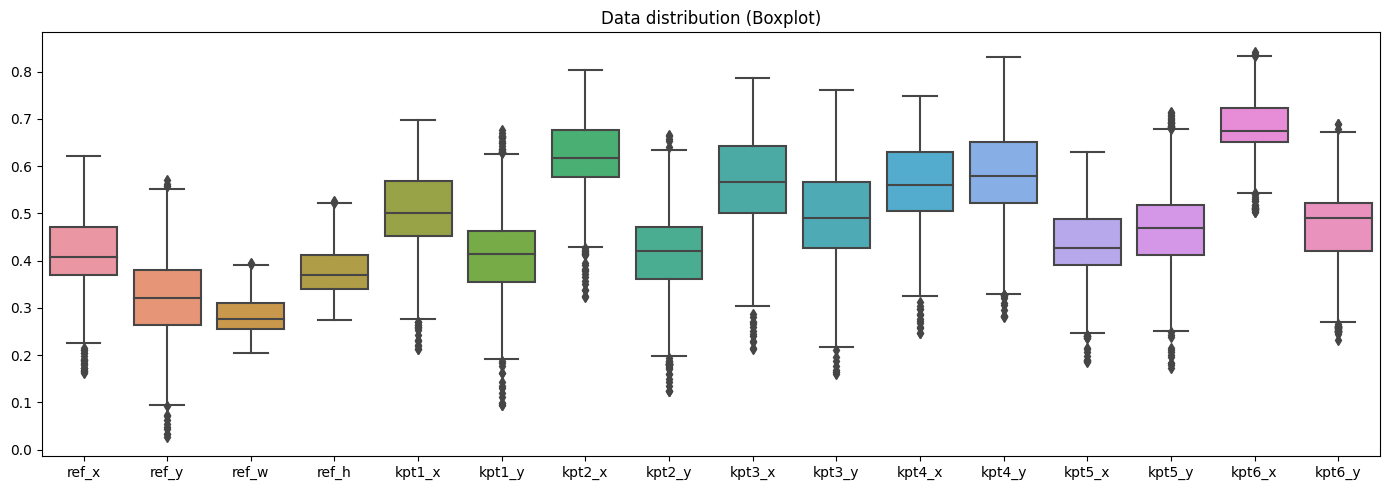

In [7]:
plt.figure(figsize=(14,5))
sns.boxplot(data.drop(['file_path','label','subject'], axis=1))
plt.title('Data distribution (Boxplot)')
plt.tight_layout()
plt.show()

### Representation of the classes from each keypoint

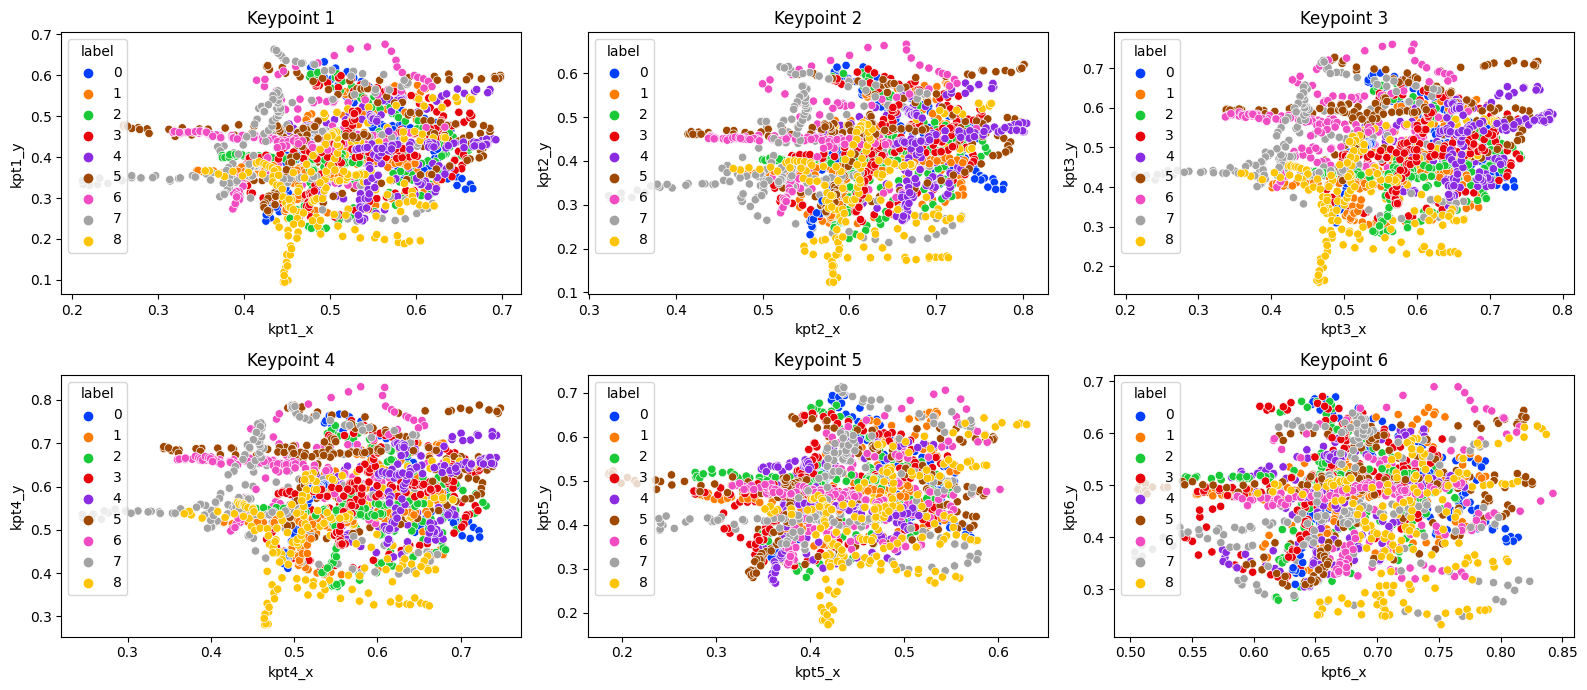

In [8]:
axs = [['kpt1_x', 'kpt2_x', 'kpt3_x', 'kpt4_x', 'kpt5_x', 'kpt6_x'],
       ['kpt1_y', 'kpt2_y', 'kpt3_y', 'kpt4_y', 'kpt5_y', 'kpt6_y']]

plt.figure(figsize=(16,7))
for i in range(len(axs[0])):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data, x=axs[0][i], y=axs[1][i], hue='label', palette='bright')
    plt.title(f'Keypoint {i+1}')
plt.tight_layout()
plt.show()

### We remove the off-set generated by the bounding box position and size to obtain a better representation of the keypoints for each class

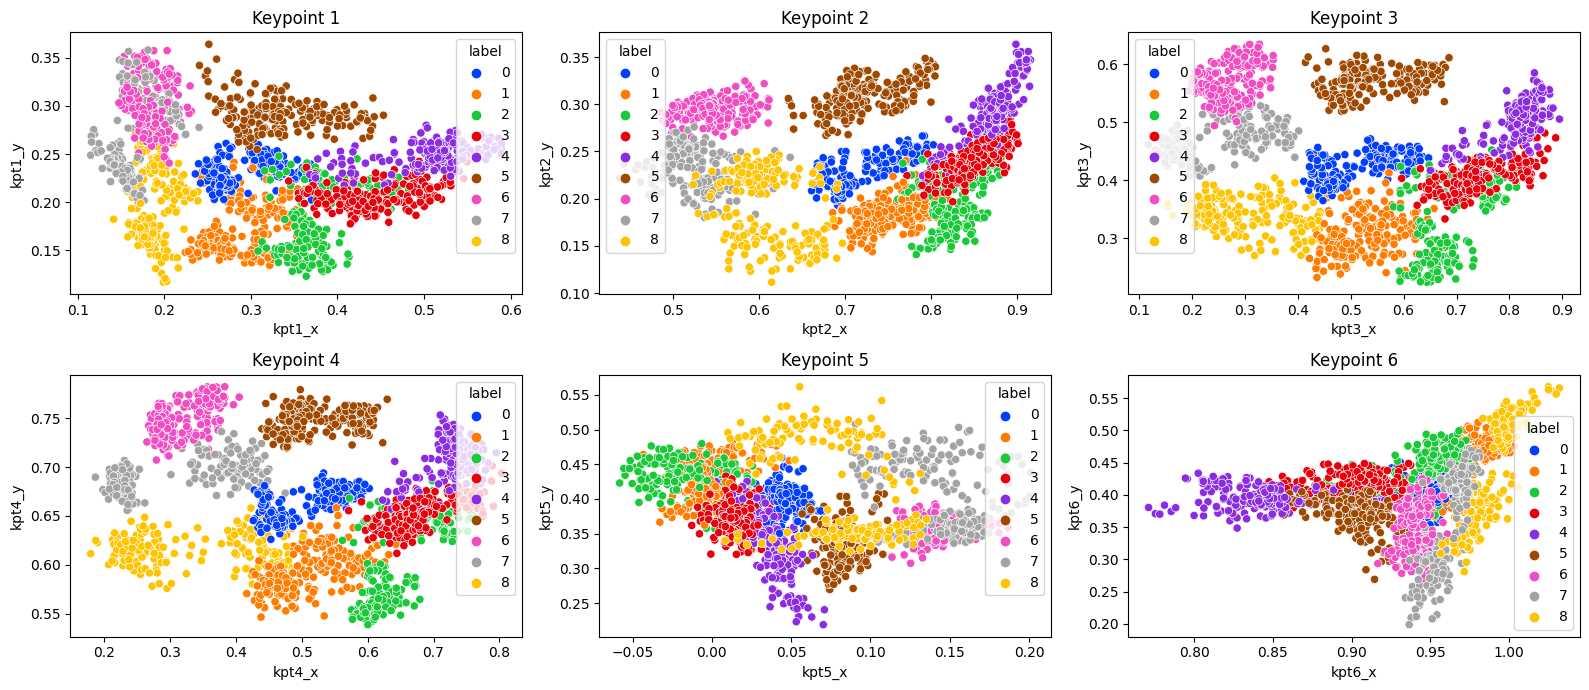

In [9]:
X = pd.concat([(data[axs[0]]-data[['ref_x']].values)/data[['ref_w']].values,
               (data[axs[1]]-data[['ref_y']].values)/data[['ref_h']].values],
               axis=1)

plt.figure(figsize=(16,7))
for i in range(len(axs[0])):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(X, x=axs[0][i], y=axs[1][i], hue=data['label'], palette='bright')
    plt.title(f'Keypoint {i+1}')
plt.tight_layout()
plt.show()

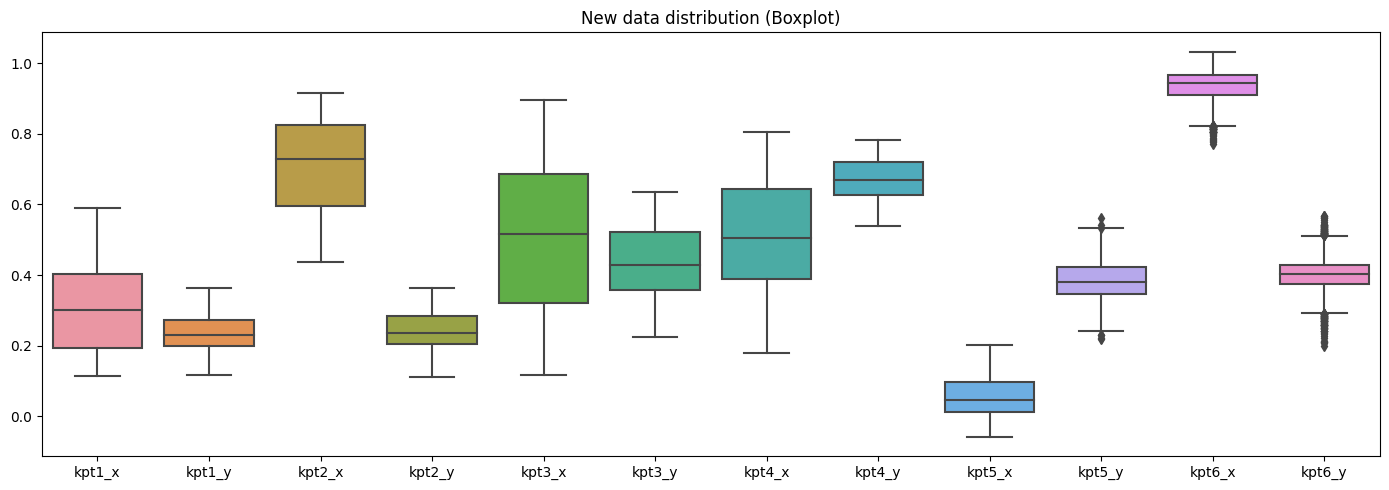

In [10]:
X = X[['kpt1_x', 'kpt1_y', 'kpt2_x', 'kpt2_y', 'kpt3_x', 'kpt3_y',
        'kpt4_x','kpt4_y', 'kpt5_x', 'kpt5_y', 'kpt6_x', 'kpt6_y']]

plt.figure(figsize=(14,5))
sns.boxplot(X)
plt.title('New data distribution (Boxplot)')
plt.tight_layout()
plt.show()

### Separate the labels from the dataset

In [11]:
y = data['label']
classes = {0:'center', 1:'up', 2:'left/up', 3:'left', 4:'left/down',
           5:'down', 6:'right/down', 7:'right', 8:'right/up'}

# Model creation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2, random_state=69, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1440, 12), (1440,), (360, 12), (360,))

## Logistic Regression

In [13]:
param_grid = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}

lr = LogisticRegression(max_iter=5000)
grid = GridSearchCV(lr, param_grid, cv=5, verbose=0, n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

{'C': 10000.0}

In [14]:
lr = LogisticRegression(C=grid.best_params_['C'], max_iter=5000)
lr.fit(X_train, y_train)

LogisticRegression(C=10000.0, max_iter=5000)

In [15]:
lr.coef_.mean(axis=0)

array([-5.05590631e-12,  1.12690104e-12,  3.25310149e-12,  6.29777711e-12,
        4.99906289e-12,  3.24362759e-11,  2.72828673e-11, -6.46774918e-12,
       -1.31143491e-11,  3.51592335e-11,  1.28308228e-11, -2.10439074e-11])

## Classification results

In [16]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('\t\tRESULTS IN TRAIN\n')
print(classification_report(y_train, pred_train, target_names=classes.values()))
print('\n')
print('\t\tRESULTS IN TEST\n')
print(classification_report(y_test, pred_test, target_names=classes.values()))

		RESULTS IN TRAIN

              precision    recall  f1-score   support

      center       0.99      1.00      1.00       160
          up       0.96      0.97      0.97       160
     left/up       0.89      0.89      0.89       160
        left       0.90      0.87      0.89       160
   left/down       0.96      0.97      0.96       160
        down       1.00      1.00      1.00       160
  right/down       1.00      1.00      1.00       160
       right       1.00      1.00      1.00       160
    right/up       0.99      0.99      0.99       160

    accuracy                           0.97      1440
   macro avg       0.97      0.97      0.97      1440
weighted avg       0.97      0.97      0.97      1440



		RESULTS IN TEST

              precision    recall  f1-score   support

      center       1.00      1.00      1.00        40
          up       0.95      0.97      0.96        40
     left/up       0.89      0.82      0.86        40
        left       0.80      0.90    

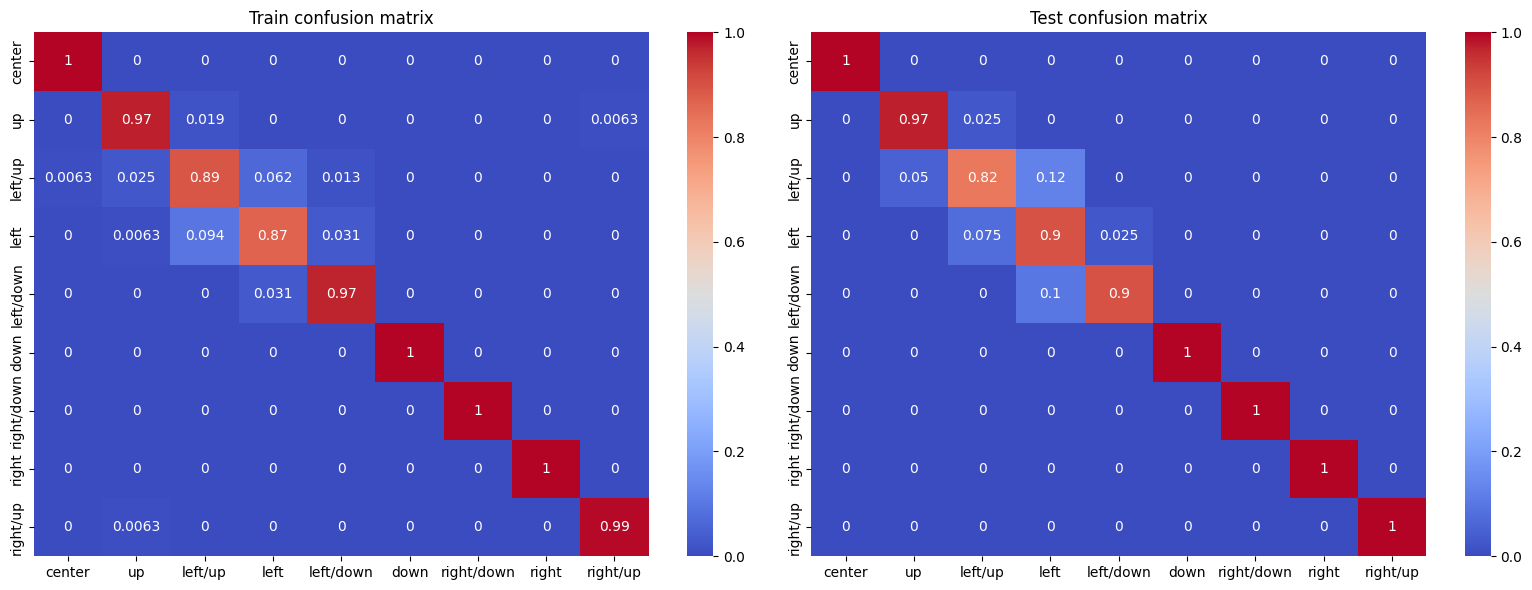

In [17]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_train, pred_train, normalize='true'),
            annot=True, cmap='coolwarm', vmin=0)
plt.title('Train confusion matrix')
plt.xticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.yticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, pred_test, normalize='true'),
            annot=True, cmap='coolwarm', vmin=0)
plt.title('Test confusion matrix')
plt.xticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.yticks(ticks=np.arange(0.5,len(classes),1), labels=classes.values())
plt.tight_layout()
plt.show()

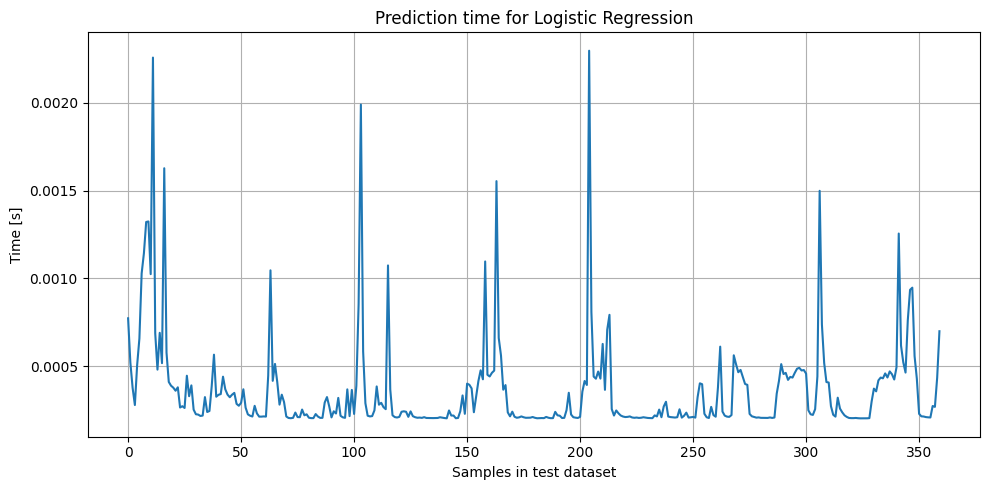

In [19]:
pred_time = []
for sample in X_test:
  start_time = time.time()
  pred = lr.predict(sample.reshape((1,-1)))
  pred_time.append(time.time()-start_time)
plt.figure(figsize=(10, 5))
plt.plot(pred_time)
plt.grid(True)
plt.title('Prediction time for Logistic Regression')
plt.xlabel('Samples in test dataset')
plt.ylabel('Time [s]')
plt.tight_layout()
plt.show()

# Save the trained model

In [25]:
# Saving the model:
with open(os.path.join('..', 'models', 'cursor_movement_model.pkl'), 'wb') as f:
    pickle.dump(lr, f)